# 1. CatBoost Overview

## 1.1 Data Preparation

### 1.1.1 CatBoost Installation

In [1]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


### 1.1.2 Data Loading

In [2]:
from catboost.datasets import titanic
import numpy as np

train_df, test_df = titanic()

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.1.3 Feature Preparation

In [3]:
# Check missing values
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [4]:
# Fill NAs
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

X = train_df.drop('Survived', axis=1)
y = train_df.Survived

### 1.1.4 Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df

## 1.2 CatBoost Basics

In [6]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

### 1.2.1 Model Training

In [7]:
model = CatBoostClassifier(
    custom_loss = [metrics.Accuracy()], # we can find the evaluation metric for loss functions
    random_seed = 42,
    logging_level = 'Silent'
)

In [8]:
from google.colab import output
output.enable_custom_widget_manager()

In [9]:
categorical_features_indices = np.where(X.dtypes != float)[0]
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 1.2.2 Cross Validation

In [10]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [11]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 355


In [12]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8294051627384961


### 1.2.3 Model Apply

In [13]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 1 0 1 0 1 0]
[[0.85473931 0.14526069]
 [0.76313031 0.23686969]
 [0.88972889 0.11027111]
 [0.87876173 0.12123827]
 [0.3611047  0.6388953 ]
 [0.90513381 0.09486619]
 [0.33434185 0.66565815]
 [0.78468564 0.21531436]
 [0.39429048 0.60570952]
 [0.94047549 0.05952451]]


## 1.3 CatBoost Features

In [14]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
# Pool stores all information about dataset (features, labeles, categorical features indices, weights and and much more)
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

### 1.3.1 Using the best model

In [15]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, best_model.predict(X_validation))
))

Simple model validation accuracy: 0.8027

Best model validation accuracy: 0.8117


### 1.3.2 Early Stopping

In [16]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 6.8 s, sys: 580 ms, total: 7.38 s
Wall time: 4.09 s


In [17]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 1.25 s, sys: 131 ms, total: 1.38 s
Wall time: 831 ms


In [18]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')

print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Simple model tree count: 500
Simple model validation accuracy: 0.8027

Early-stopped model tree count: 108
Early-stopped model validation accuracy: 0.8117


### 1.3.3 Baseline

In [19]:
# use pre-training results (baseline) for training
current_params = params.copy()
current_params.update({
    'iterations': 10
})
model = CatBoostClassifier(**current_params).fit(X_train, y_train, categorical_features_indices)
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
# Fit new model
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline);

### 1.3.4 Snapshot

recovering training after an interruption or for starting training with previous results

In [20]:
params_with_snapshot = params.copy()
params_with_snapshot.update({
    'iterations': 5,
    'learning_rate': 0.5,
    'logging_level': 'Verbose'
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)
params_with_snapshot.update({
    'iterations': 10,
    'learning_rate': 0.1,
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)

0:	test: 0.8627369	best: 0.8627369 (0)	total: 2.68ms	remaining: 10.7ms
1:	test: 0.8643300	best: 0.8643300 (1)	total: 4.94ms	remaining: 7.41ms
2:	test: 0.8654620	best: 0.8654620 (2)	total: 10.8ms	remaining: 7.23ms
3:	test: 0.8664263	best: 0.8664263 (3)	total: 13.4ms	remaining: 3.36ms
4:	test: 0.8714573	best: 0.8714573 (4)	total: 16ms	remaining: 0us

bestTest = 0.8714573201
bestIteration = 4

5:	test: 0.8716250	best: 0.8716250 (5)	total: 20.6ms	remaining: 18.3ms
6:	test: 0.8723377	best: 0.8723377 (6)	total: 24.8ms	remaining: 13.2ms
7:	test: 0.8728409	best: 0.8728409 (7)	total: 28.1ms	remaining: 8.08ms
8:	test: 0.8729247	best: 0.8729247 (8)	total: 29.7ms	remaining: 3.44ms
9:	test: 0.8722539	best: 0.8729247 (8)	total: 32.4ms	remaining: 0us

bestTest = 0.8729247023
bestIteration = 8



### 1.3.5 Staged Predict

Iteratively get predictions for a given range of trees

In [21]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.53597869 0.41039128 0.42057479 0.64281031 0.46576685]
First class probabilities using the first 5 trees: [0.63722688 0.42492029 0.46209302 0.70926021 0.44280772]
First class probabilities using the first 7 trees: [0.66964764 0.42409144 0.46124982 0.76101033 0.47205986]


### 1.3.6 Feature Importance

In [22]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sex: 59.004092014268586
Pclass: 16.340887169747035
Ticket: 6.028107169932204
Cabin: 3.8347242202560192
Fare: 3.712969667934384
Age: 3.484451204182482
Parch: 3.378089740355865
Embarked: 2.3139994072899555
SibSp: 1.9026794060334504
PassengerId: 0.0
Name: 0.0


### 1.3.7 Evaluation Metrics

In [23]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
eval_metrics = model.eval_metrics(validate_pool, [metrics.AUC()], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
print(eval_metrics['AUC'][:6])

[0.8627368774106994, 0.8623176253563642, 0.8602213650846889, 0.8514170719436525, 0.8495723629045783, 0.8569092738554419]


### 1.3.8 Learning Processes Comparison

In [25]:
model1 = CatBoostClassifier(iterations=100, depth=1, train_dir='model_depth_1/', logging_level='Silent')
model1.fit(train_pool, eval_set=validate_pool)
model2 = CatBoostClassifier(iterations=100, depth=5, train_dir='model_depth_5/', logging_level='Silent')
model2.fit(train_pool, eval_set=validate_pool);

In [26]:
from catboost import MetricVisualizer
widget = MetricVisualizer(['model_depth_1', 'model_depth_5'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 1.3.9 Save and load the model

In [27]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

## 1.4 Parameter Tuning

In [28]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.Accuracy(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params(),
        logging_level='Silent',
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [30]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 50/50 [09:35<00:00, 11.51s/it, best loss: 0.16386083052749711]
{'l2_leaf_reg': 1.0, 'learning_rate': 0.0450866712211308}


In [31]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

Training on fold [0/3]

bestTest = 0.8417508418
bestIteration = 262

Training on fold [1/3]

bestTest = 0.8451178451
bestIteration = 269

Training on fold [2/3]

bestTest = 0.8215488215
bestIteration = 284



In [32]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8361391694725029


---

# 2. CatBoost Tasks

In [33]:
!pip install catboost
!pip install shap
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## 2.1 Reading the data


In [34]:
import os
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

import catboost
from catboost import datasets, metrics
from catboost import *

In [35]:
train_df, test_df = catboost.datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## 2.2 Preparing data

In [36]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_df.to_csv(os.path.join(dataset_dir, 'train.csv'), index=False)
test_df.to_csv(os.path.join(dataset_dir, 'test.csv'), index=False)

In [37]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [38]:
from catboost.utils import create_cd
feature_names = dict(list(enumerate(train_df.keys()[1:])))
    
create_cd(
    label=0,
    cat_features=list(range(1, train_df.shape[1])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [39]:
feature_names

{0: 'RESOURCE',
 1: 'MGR_ID',
 2: 'ROLE_ROLLUP_1',
 3: 'ROLE_ROLLUP_2',
 4: 'ROLE_DEPTNAME',
 5: 'ROLE_TITLE',
 6: 'ROLE_FAMILY_DESC',
 7: 'ROLE_FAMILY',
 8: 'ROLE_CODE'}

In [40]:
# Create pull file
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix. This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# Categorial features in catboost must have type str

pool4 = Pool(
    data=FeaturesData(cat_feature_data=X_prepared, cat_feature_names=list(X)),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape) + 
      '\ndataset 3:' + str(pool3.shape) + '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## 2.3 Split into train and validation

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

## 2.4 Train the model

In [42]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=0,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'random_seed': 0}


## 2.5 Stdout of the training

In [43]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    verbose=3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.434276
0:	learn: 0.4254575	test: 0.4239191	best: 0.4239191 (0)	total: 27.8ms	remaining: 389ms
3:	learn: 0.2341798	test: 0.2315195	best: 0.2315195 (3)	total: 118ms	remaining: 325ms
6:	learn: 0.1897462	test: 0.1801328	best: 0.1801328 (6)	total: 270ms	remaining: 308ms
9:	learn: 0.1805353	test: 0.1676350	best: 0.1676350 (9)	total: 387ms	remaining: 194ms
12:	learn: 0.1777267	test: 0.1642904	best: 0.1642904 (12)	total: 539ms	remaining: 83ms
14:	learn: 0.1755570	test: 0.1627501	best: 0.1627501 (14)	total: 623ms	remaining: 0us

bestTest = 0.1627500973
bestIteration = 14



## 2.6 Random Seed

In [44]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.5
0:	learn: 0.3967366	test: 0.3950896	best: 0.3950896 (0)	total: 71.2ms	remaining: 285ms
1:	learn: 0.2941275	test: 0.2925750	best: 0.2925750 (1)	total: 100ms	remaining: 150ms
2:	learn: 0.2472126	test: 0.2453665	best: 0.2453665 (2)	total: 149ms	remaining: 99.4ms
3:	learn: 0.2219962	test: 0.2180716	best: 0.2180716 (3)	total: 209ms	remaining: 52.3ms
4:	learn: 0.2018652	test: 0.1945321	best: 0.1945321 (4)	total: 270ms	remaining: 0us

bestTest = 0.1945320687
bestIteration = 4



In [45]:
random_seed = model.random_seed_
print('Used random seed = ' + str(random_seed))
model = CatBoostClassifier(
    iterations=5,
    random_seed=random_seed
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Used random seed = 0
Learning rate set to 0.5
0:	learn: 0.3967366	test: 0.3950896	best: 0.3950896 (0)	total: 49.1ms	remaining: 196ms
1:	learn: 0.2941275	test: 0.2925750	best: 0.2925750 (1)	total: 79.7ms	remaining: 120ms
2:	learn: 0.2472126	test: 0.2453665	best: 0.2453665 (2)	total: 113ms	remaining: 75.2ms
3:	learn: 0.2219962	test: 0.2180716	best: 0.2180716 (3)	total: 151ms	remaining: 37.7ms
4:	learn: 0.2018652	test: 0.1945321	best: 0.1945321 (4)	total: 189ms	remaining: 0us

bestTest = 0.1945320687
bestIteration = 4



## 2.7 Metrics calculation and graph plotting

In [46]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=[metrics.Accuracy()]
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 2.8 Model Comparison

In [47]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=50,
    random_seed=64,
    train_dir='learning_rate_0.5'
)

model2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=50,
    random_seed=64,
    train_dir='learning_rate_0.05'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=10
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=10
)

0:	learn: 0.3972443	test: 0.3958490	best: 0.3958490 (0)	total: 54.7ms	remaining: 2.68s
10:	learn: 0.1786828	test: 0.1646876	best: 0.1646876 (10)	total: 416ms	remaining: 1.47s
20:	learn: 0.1721037	test: 0.1600250	best: 0.1598748 (19)	total: 822ms	remaining: 1.14s
30:	learn: 0.1689205	test: 0.1577794	best: 0.1577794 (30)	total: 1.13s	remaining: 693ms
40:	learn: 0.1670458	test: 0.1575376	best: 0.1575376 (40)	total: 1.3s	remaining: 287ms
49:	learn: 0.1647194	test: 0.1567791	best: 0.1566963 (47)	total: 1.46s	remaining: 0us

bestTest = 0.1566962517
bestIteration = 47

Shrink model to first 48 iterations.
0:	learn: 0.6550994	test: 0.6549143	best: 0.6549143 (0)	total: 22.3ms	remaining: 1.09s
10:	learn: 0.4176872	test: 0.4165343	best: 0.4165343 (10)	total: 140ms	remaining: 496ms
20:	learn: 0.3114356	test: 0.3097068	best: 0.3097068 (20)	total: 270ms	remaining: 373ms
30:	learn: 0.2577563	test: 0.2550672	best: 0.2550672 (30)	total: 412ms	remaining: 253ms
40:	learn: 0.2276042	test: 0.2238488	best: 

## 2.9 Best Iteration

If a validation dataset is present then after training, the model is shrinked to a number of trees when it got best evaluation metric value on validation dataset. By default evaluation metric is the optimized metric. But you can set evaluation metric to some other metric. In the example below evaluation metric is Accuracy.

In [48]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric=metrics.Accuracy()
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 84


#### Set the `use_best_model = False` if we want to turn this function off

In [51]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric=metrics.Accuracy(),
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 2.10 Cross-validation

In [52]:
from catboost import cv

params = {}
params['loss_function'] = metrics.Logloss()
params['iterations'] = 80
params['custom_loss'] = metrics.AUC()
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.15425211
bestIteration = 35

Training on fold [3/5]

bestTest = 0.1433537051
bestIteration = 55

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [53]:
print(cv_data[0:4])

   iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.302367          0.004317            0.302196   
1           1           0.227370          0.007679            0.228497   
2           2           0.190856          0.006917            0.196796   
3           3           0.178884          0.007455            0.186682   

   train-Logloss-std  test-AUC-mean  test-AUC-std  
0           0.004517       0.513577      0.030360  
1           0.005126       0.642263      0.048004  
2           0.003999       0.791709      0.011361  
3           0.003242       0.813889      0.009362  


## 2.11 Overfitting Detector

In [54]:
# Early Stopping
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 2.12 SHAP

In [55]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

Learning rate set to 0.137885
0:	learn: 0.5379892	total: 39.6ms	remaining: 11.8s
50:	learn: 0.1642268	total: 2.54s	remaining: 12.4s
100:	learn: 0.1579621	total: 4.27s	remaining: 8.42s
150:	learn: 0.1533024	total: 5.99s	remaining: 5.91s
200:	learn: 0.1486749	total: 7.74s	remaining: 3.81s
250:	learn: 0.1446334	total: 9.5s	remaining: 1.85s
299:	learn: 0.1411890	total: 11.3s	remaining: 0us


In [56]:
# SHAP with provides a basic view of which features are important for a given object. 
pool1 = Pool(data=X, label=y, cat_features=cat_features)
shap_info = model.get_feature_importance(data=pool1, type='ShapValues', verbose=10000)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
print(shap_values.shape)

Processing trees...
128/300 trees processed	passed time: 141ms	remaining time: 190ms
300/300 trees processed	passed time: 459ms	remaining time: 0us
Processing documents...
128/32769 documents processed	passed time: 21.1ms	remaining time: 5.37s
10112/32769 documents processed	passed time: 1.15s	remaining time: 2.59s
20096/32769 documents processed	passed time: 1.86s	remaining time: 1.17s
30080/32769 documents processed	passed time: 2.57s	remaining time: 230ms
(32769, 9)


In [57]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9948
Formula raw prediction = 5.2546




In [58]:
import shap
shap.initjs()
shap.force_plot(base_value=base_values[0], shap_values=shap_values[0], features=X.iloc[0])

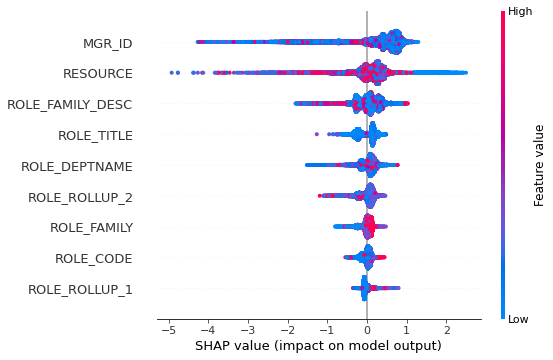

In [59]:
shap.summary_plot(shap_values, X)

## 2.13 Hyperparameter

In [60]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5, # speed up training w/t affect quality, very useful if you have hundreds of features
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    border_count=32)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

---

# 3. CatBoost For Classification